In [17]:
import librosa
import soundfile as sf
import torchaudio
import torch
import matplotlib.pyplot as plt
import pandas as pd

In [56]:
def spectrogram(waveform, sr, chunk_size_s=None, overlap=0):
    if chunk_size_s == None:
        return torchaudio.transforms.MelSpectrogram(n_mels=80, n_fft=270)(torch.Tensor(waveform).reshape(1,-1))

    chunk_size = int(chunk_size_s * sr)

    def chunk_waveform(waveform, chunk_size, overlap):
        idx = 0
        # overlap_chunk = 0
        overlap_chunk = int(overlap * chunk_size)
        while idx + chunk_size - overlap_chunk <= len(waveform):
            yield waveform[idx:idx + chunk_size - overlap_chunk]
            idx += chunk_size - overlap_chunk

    chunks = torch.FloatTensor(list(chunk_waveform(waveform, chunk_size, overlap)))
#     chunk = chunks[0]

    specgram = torchaudio.transforms.MelSpectrogram(n_mels=80, n_fft=270)(chunks)
#     specgram = torchaudio.transforms.MelSpectrogram(n_mels=80, n_fft=256)(chunk.reshape(1,-1))
    return specgram

In [86]:
def spectrogram(waveform, sr, chunk_size_s=None, overlap=0, *, n_mels=80, n_fft=256):
    if chunk_size_s == None:
        return torchaudio.transforms.MelSpectrogram(n_mels=n_mels, n_fft=n_fft)(torch.Tensor(waveform).reshape(1,-1))

    chunk_size = int(chunk_size_s * sr)
    chunks = torch.FloatTensor(list(chunk_waveform(waveform, chunk_size, overlap)))
    specgram = torchaudio.transforms.MelSpectrogram(n_mels=n_mels, n_fft=n_fft)(chunks)
    return specgram

def chunk_waveform(waveform, chunk_size, overlap):
    idx = 0
    # overlap_chunk = 0
    overlap_chunk = int(overlap * chunk_size)
    while idx + chunk_size - overlap_chunk <= len(waveform):
        yield waveform[idx:idx + chunk_size - overlap_chunk]
        idx += chunk_size - overlap_chunk

In [134]:
# filepath = r"C:\Users\jiyun\Desktop\Jiyu\2020-2021\ESC499 - Thesis\WaveNet\magnatagatune\data\notes\C_9.mp3"
filepath = r"C:\Users\jiyun\Desktop\Jiyu\2020-2021\ESC499 - Thesis\WaveNet\magnatagatune\data\simple\macdonald-piano.mp3"
chunk_size_s = None
overlap = 0

waveform, sr = librosa.load(filepath)
waveform = waveform[:int(sr*1.5)] # first note = "C" (3rd)
specgram = spectrogram(waveform, sr, chunk_size_s=chunk_size_s, overlap=overlap)

In [135]:
specgram.shape

torch.Size([1, 80, 259])

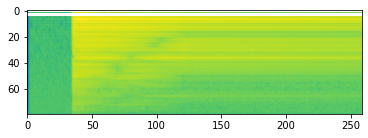

In [136]:
plt.imshow(specgram.log2()[0,:,:].detach().numpy())

In [137]:
sf.write("test.wav", waveform, sr)

In [28]:
import sys
sys.path.insert(1, r"C:\Users\jiyun\Desktop\Jiyu\2020-2021\ESC499 - Thesis\WaveNet\wavenet_pytorch")
from classifier_model import Net

In [127]:
state_path = r"C:\Users\jiyun\Desktop\Jiyu\2020-2021\ESC499 - Thesis\WaveNet\wavenet_pytorch\model\classifier_bs10_lr0.002_epoch150.pt"
net = Net()
net.load_state_dict(torch.load(state_path))
net.eval()

Net(
  (conv1): Conv1d(80, 16, kernel_size=(7,), stride=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(16, 32, kernel_size=(3,), stride=(1,))
  (fc1): Linear(in_features=2080, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=6, bias=True)
)

In [138]:
specgram.shape

torch.Size([1, 80, 259])

In [139]:
spec_data = torch.zeros(1, 80, 270)
spec_data[:,:,:specgram[0].shape[-1]] = specgram[0] #PADDING WITH ZEROS

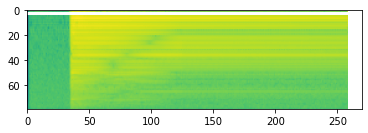

In [140]:
plt.imshow(spec_data.log2()[0,:,:].detach().numpy())

In [141]:
output = net(spec_data)

In [142]:
output

tensor([[ -49.0909,  -22.9055,   74.6808, -163.1805, -204.8701, -255.4872]],
       grad_fn=<AddmmBackward>)

***
### Automatically detecting changes in spectrogram